# ORIE 4741 Project
### Netflix Success Predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
netflix=pd.read_csv('datasets/netflix.csv')

In [3]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with simple NaN values: 

In [4]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


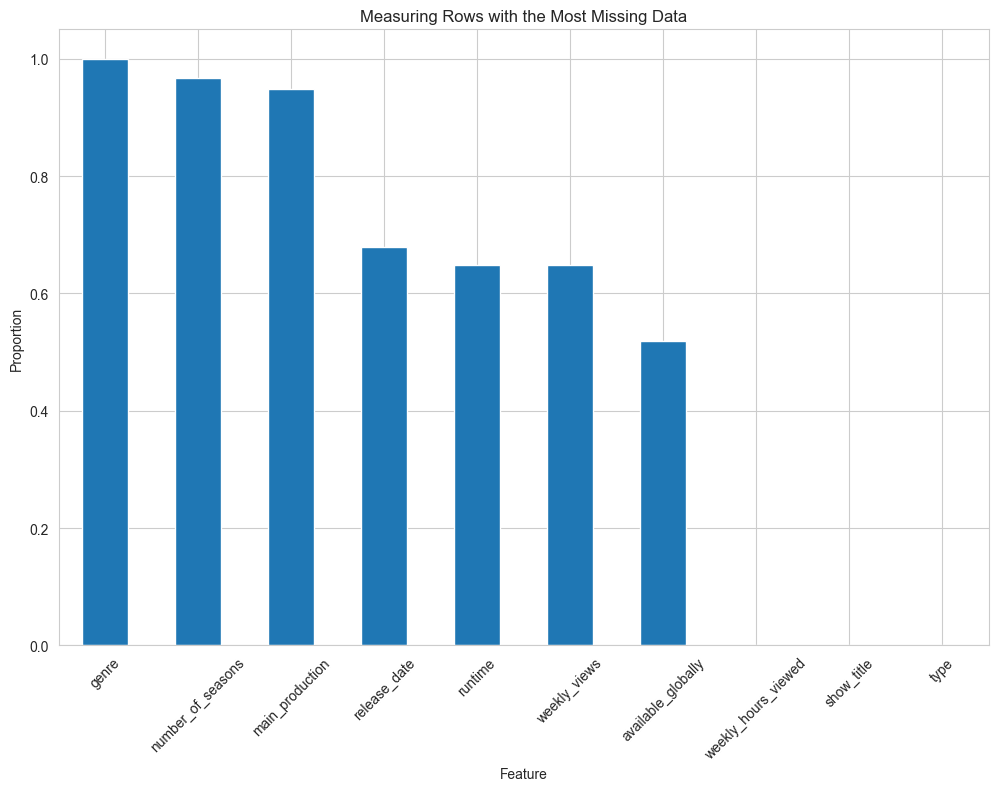

In [5]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


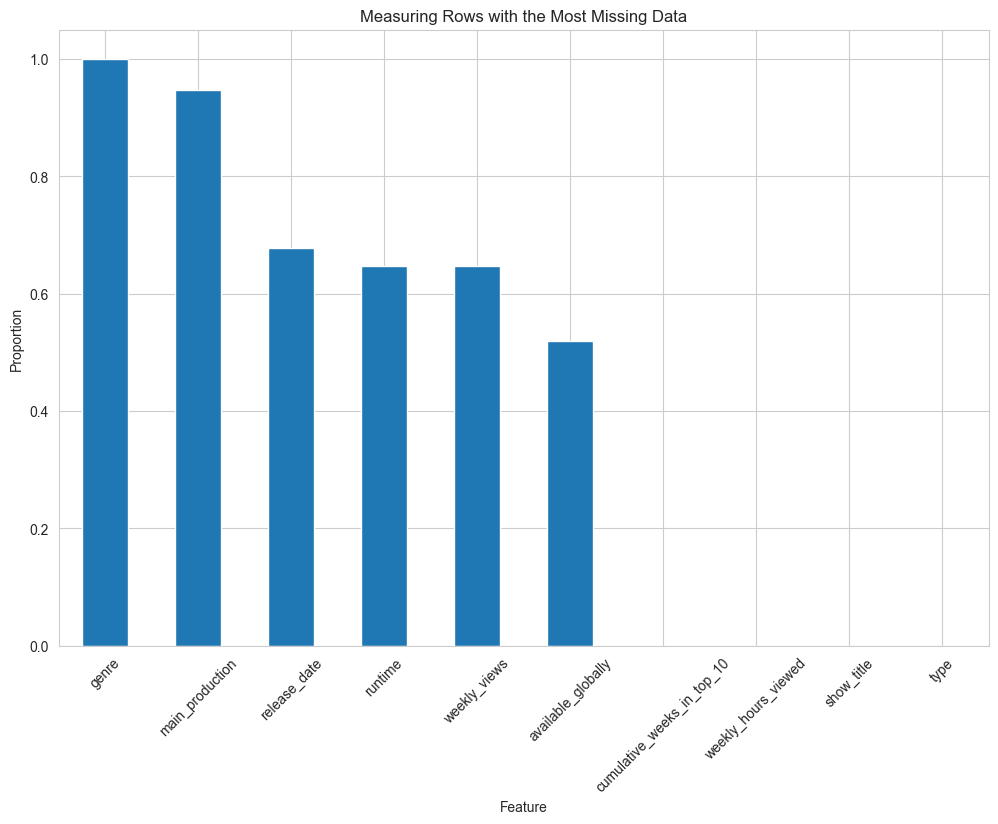

In [6]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [7]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,False,True,True,False,True,False
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,False,True,True,False,False,False
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,False,True,True,False,False,False
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,False,True,True,False,False,False
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,False,True,True,False,False,False
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,False,True,True,False,False,True
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,False,True,True,False,False,False
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,False,True,True,False,True,False


#### Dealing with Missing Data


In [8]:
from numpy.linalg import svd

In [9]:
netflix_fill=netflix.copy()

In [10]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix_fill['available_globally_Yes'] = netflix_fill.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [11]:
netflix_np=netflix_fill[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_np=netflix_np.astype(float)

In [12]:
column_means = np.nanmean(netflix_np, axis=0)
nan_indices = np.isnan(netflix_np)
netflix_np[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

In [13]:
netflix_copy = netflix[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_copy=netflix_copy.astype(float)
netflix_copy2=netflix_copy.copy()

In [14]:
#Normalize ** DONT KNOW 
normalized_matrix = (netflix_np - np.mean(netflix_np, axis=0)) / np.std(netflix_np, axis=0)
U, S, VT = svd(normalized_matrix)

rank = 5
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
VT_ranked = VT[:rank, :]
reconstructed_matrix = U_ranked.dot(S_ranked).dot(VT_ranked)

denormalized_matrix = (reconstructed_matrix * np.std(netflix_np, axis=0)) + np.mean(netflix_np, axis=0)

missing_indices = np.isnan(netflix_copy)
netflix_copy[missing_indices] = denormalized_matrix[missing_indices]



In [15]:
netflix_complete = pd.DataFrame(netflix_copy, columns=['weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix_complete['weekly_hours_viewed']=netflix['weekly_hours_viewed']
netflix_complete.head()

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,6825000.0
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6900000.0
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7415000.0
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6795000.0
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8210000.0


In [16]:
#double check this but i dropped these columns because they are one hot encoded so we shouldn't need both
netflix_complete=netflix_complete.drop(columns=['language_Non-English', 'type_TV', 'available_globally_Yes'])

In [17]:
netflix=netflix_complete.copy()

In [18]:
netflix

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,type_Films,available_globally_No,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,6.825000e+06
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,0.0,6.900000e+06
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,7.415000e+06
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,6.795000e+06
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,1.0,1.0,8.210000e+06
...,...,...,...,...,...,...,...,...,...
1860,1.300000e+06,1.0,1.850000,0.0,0.0,0.0,1.0,0.0,2.400000e+06
1861,4.173987e+06,4.0,1.865367,0.0,0.0,0.0,1.0,0.0,1.249250e+07
1862,2.550000e+06,2.0,1.933300,0.0,0.0,0.0,1.0,0.0,4.950000e+06
1863,2.782683e+06,3.0,1.480532,0.0,0.0,0.0,1.0,1.0,2.910000e+06


## Modeling
Now that the feature engineering is completed. We will explore different models to find the best fit to predict our success variable
We will explore
- Linear Regression
- Polynomial Fits
- Regression Trees

In [19]:
netflix

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,type_Films,available_globally_No,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,6.825000e+06
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,0.0,6.900000e+06
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,7.415000e+06
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,6.795000e+06
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,1.0,1.0,8.210000e+06
...,...,...,...,...,...,...,...,...,...
1860,1.300000e+06,1.0,1.850000,0.0,0.0,0.0,1.0,0.0,2.400000e+06
1861,4.173987e+06,4.0,1.865367,0.0,0.0,0.0,1.0,0.0,1.249250e+07
1862,2.550000e+06,2.0,1.933300,0.0,0.0,0.0,1.0,0.0,4.950000e+06
1863,2.782683e+06,3.0,1.480532,0.0,0.0,0.0,1.0,1.0,2.910000e+06


# Standardization and Splitting

In [20]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys 

netflix_std = StandardScaler().fit_transform(netflix)

netflix_complete = pd.DataFrame(netflix_std, columns=['weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 
                                                  'type_Films', 
                                                  'available_globally_No', 'weekly_hours_viewed'])

netflix_complete.head()

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,type_Films,available_globally_No,weekly_hours_viewed
0,-0.644959,-0.28472,-0.743534,-0.145597,-0.080474,-1.028834,0.741816,2.010110,-0.492864
1,-0.268775,-0.28472,-0.448582,-0.145597,-0.080474,-1.028834,0.741816,-0.497485,-0.486369
2,-0.087722,-0.28472,-0.562037,-0.145597,-0.080474,-1.028834,0.741816,-0.497485,-0.441764
3,-0.087722,-0.28472,-0.562037,-0.145597,-0.080474,-1.028834,0.741816,-0.497485,-0.495463
4,-0.107654,-0.28472,-0.761953,-0.145597,-0.080474,0.971974,0.741816,2.010110,-0.372909


In [21]:
X_std = netflix_std[:, :8]
y_std = netflix_std[:, 8]

X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, test_size=0.2, random_state=42)


print("shape of X_train ", X_train.shape)
print("shape of y_train ", y_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_test ", y_test.shape)



shape of X_train  (1492, 8)
shape of y_train  (1492,)
shape of X_test  (373, 8)
shape of y_test  (373,)


In [22]:
X_train

array([[-0.17096392, -0.66373787, -0.65304717, ...,  0.97197433,
         0.74181597, -0.49748532],
       [ 0.32639496, -0.66373787, -0.58778853, ...,  0.97197433,
         0.74181597, -0.49748532],
       [ 0.51371321, -0.66373787, -0.59578522, ...,  0.97197433,
         0.74181597,  2.01010958],
       ...,
       [ 0.16648409,  1.61036708,  2.65902427, ...,  0.97197433,
        -1.34804323, -0.49748532],
       [ 0.87738185,  3.88447202,  1.17583041, ..., -1.02883376,
        -1.34804323, -0.49748532],
       [ 0.44958247, -0.28472038, -0.58045608, ...,  0.97197433,
         0.74181597, -0.49748532]])

# Simple Linear Regression

In [23]:
linear_model = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linear_pred = linear_model.predict(X_train)

In [24]:
#Vizualizations for the linear model made 

def plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()
  

def plot_residuals (y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='-')
  plt.show()


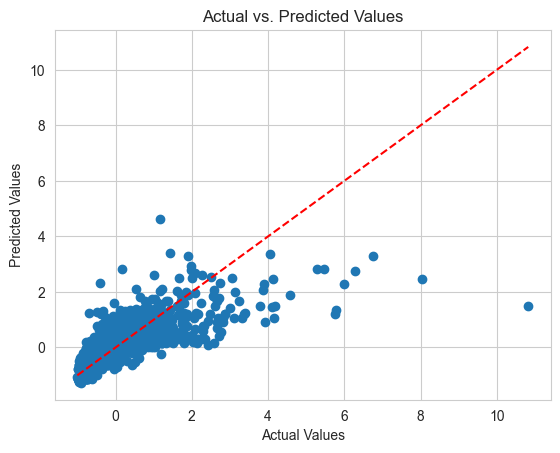

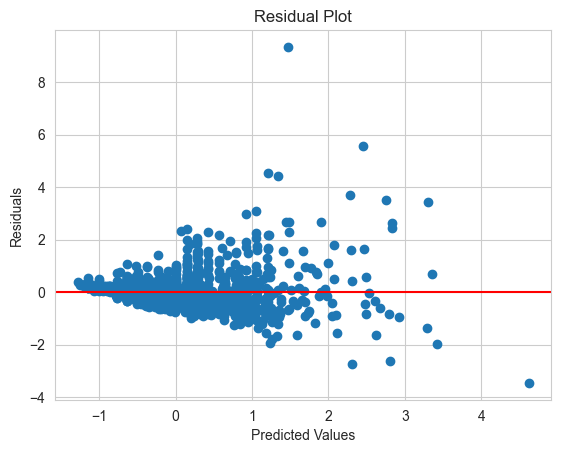

In [25]:
plot_predicted_v_actual(y_train, linear_pred)
plot_residuals(y_train, linear_pred)


The residual plot informs us that the residual (difference between the predicted and actual value) increases as the predicted values increases in size. This is a symptom of heteroscedasticity (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/). Hence, we will employ regression techinques to reduce this. 


In [26]:
from sklearn.metrics import r2_score, mean_squared_error
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred)
print("linear MSE score: ", mse_lin) #whoops we were printing out the r2 score again here

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_lin = cross_val_score(LinearRegression(), X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results_lin}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin.mean(), cross_val_results_lin.std()))



linear R^2 score:  0.5605274033764225
linear MSE score:  0.450182020228847
Cross-Validation Results (Accuracy): [0.64996453 0.57565537 0.41547032 0.67342388 0.5953813  0.59070962
 0.50424602 0.53634601 0.55372164 0.51100335]
0.56 accuracy with a standard deviation of 0.07


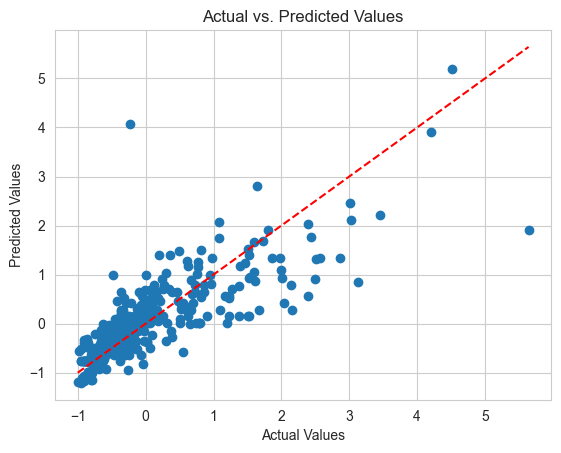

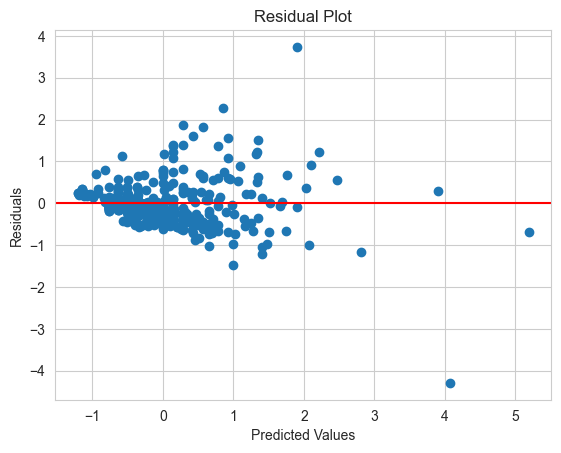

In [27]:
linear_test = linear_model.predict(X_test)
plot_predicted_v_actual(y_test, linear_test)
plot_residuals(y_test, linear_test)

In [28]:
#calculating the R-squared score 
r_squared_lin = r2_score(y_test, linear_test)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_test, linear_test)
print("linear MSE score: ", mse_lin) 

linear R^2 score:  0.6346545948234228
linear MSE score:  0.32964278531418056


# Adding Regression Methods 

In [29]:
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys 
#doing plain ridge 
a = 0.65

ridge =  Ridge(fit_intercept=True, alpha=a)
ridge_lin_trial = ridge.fit(X_train, y_train)
ridge_predictions= ridge_lin_trial.predict(X_test)
mse_ridge_lin_trial = mean_squared_error(y_test, ridge_predictions)

print("pre :",mse_ridge_lin_trial )

pre : 0.32964302433595366


In [30]:
import math

In [31]:
alpha_values = [0,0.00001, 0.0001, 0.001, 0.003, 0.0035, 0.004, 0.005,  0.1 , 1]
max_r2_score = 0
min_MSE = math.inf
method = ""
alpha_min = 0

#Attempting Ridge for data before PCA
for a in alpha_values:
  print("ALPHA VALUE IS :", a)
  ridge_lin = Ridge(fit_intercept=True, alpha=a).fit(X_train, y_train)
  ridge_predictions= ridge_lin.predict(X_test)

  mse_ridge_lin = mean_squared_error(y_test, ridge_predictions)
  print("Ridge MSE: ", mse_ridge_lin)

  r2_ridge_lin = r2_score(y_test, ridge_predictions)
  # print("Ridge linear R^2 score: ", r2_ridge_lin)

  if mse_ridge_lin < min_MSE:
    method = "ridge"
    alpha_min = a
    min_MSE = mse_ridge_lin

  lasso_lin =  Lasso(fit_intercept=True, alpha = a).fit(X_train, y_train)
  lasso_predictions= lasso_lin.predict(X_test)

  mse_lasso_lin = mean_squared_error(y_test, lasso_predictions)
  print("Lasso MSE: ", mse_lasso_lin)

  r2_lasso_lin = r2_score(y_test, lasso_predictions)
  # print("Lasso linear R^2 score:", r2_lasso_lin)

  if mse_lasso_lin < min_MSE:
    method = "lasso"
    alpha_min = a
    min_MSE = mse_lasso_lin

print("Consolidated values: ")
print("METHOD :", method)
print("ALPHA :",alpha_min)
print("MIN ERROR :", min_MSE)


ALPHA VALUE IS : 0
Ridge MSE:  0.3296427853141802
Lasso MSE:  0.3296427853141805
ALPHA VALUE IS : 1e-05
Ridge MSE:  0.32964278531704433
Lasso MSE:  0.32964181514540186
ALPHA VALUE IS : 0.0001
Ridge MSE:  0.3296427853428225
Lasso MSE:  0.329633023945662
ALPHA VALUE IS : 0.001
Ridge MSE:  0.32964278560071514
Lasso MSE:  0.32957204102169235
ALPHA VALUE IS : 0.003
Ridge MSE:  0.32964278617453713
Lasso MSE:  0.32949833457868405
ALPHA VALUE IS : 0.0035
Ridge MSE:  0.3296427863181492
Lasso MSE:  0.3294927453482972
ALPHA VALUE IS : 0.004
Ridge MSE:  0.3296427864618241
Lasso MSE:  0.32949229107005623
ALPHA VALUE IS : 0.005
Ridge MSE:  0.3296427867493619
Lasso MSE:  0.32950678737001265
ALPHA VALUE IS : 0.1
Ridge MSE:  0.3296428152083248
Lasso MSE:  0.3588413308952503
ALPHA VALUE IS : 1


/Users/andreasiby/Documents/messy data/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/andreasiby/Documents/messy data/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/andreasiby/Documents/messy data/ORIE4741FinalProject/libs/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e+02, tolerance: 1.528e-01 Linear regression models with null weight for the l1 regularization

Ridge MSE:  0.32964319668830105
Lasso MSE:  0.9025866868907988
Consolidated values: 
METHOD : lasso
ALPHA : 0.004
MIN ERROR : 0.32949229107005623


In [41]:
lasso_model_final = Lasso(fit_intercept=True, alpha = 0.004).fit(X_train, y_train)
cross_val_lasso = cross_val_score(lasso_model_final, X_train, y_train, cv=10)
avg_cross_val_lasso = cross_val_lasso.mean()
print("Average cross validation score for lasso with alpha = 0.004 :", avg_cross_val_lasso)


Average cross validation score for lasso with alpha = 0.004 : 0.5518792875878954


### Consolidation of Regression results 
* METHOD : lasso
* ALPHA : 0.004
* MIN ERROR : 0.32949229107005623

/var/folders/97/jtz2kttn1cl7hjg0k1lnnk640000gn/T/ipykernel_30235/2950329206.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(netflix['weekly_hours_viewed'])


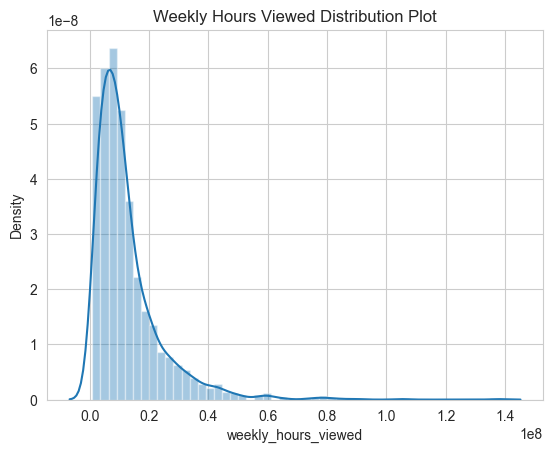

In [32]:
# Data distribution
plt.title('Weekly Hours Viewed Distribution Plot')
sns.distplot(netflix['weekly_hours_viewed'])
plt.show()

# Polynomial Model

In [33]:
#y = (netflix["weekly_hours_viewed"]).values
#X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X_train)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y_train)
#Predict results
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
#lr_2.fit(pr.fit_transform(X_test), y_test)
y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))


In [35]:
def poly_plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot(y_train, lr_2.predict(pr.fit_transform(X_train)), color = 'firebrick', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()

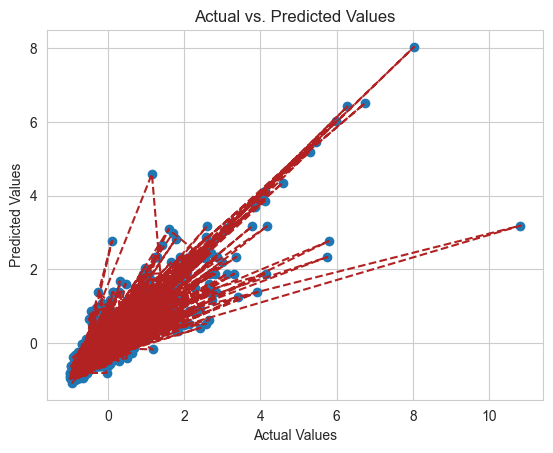

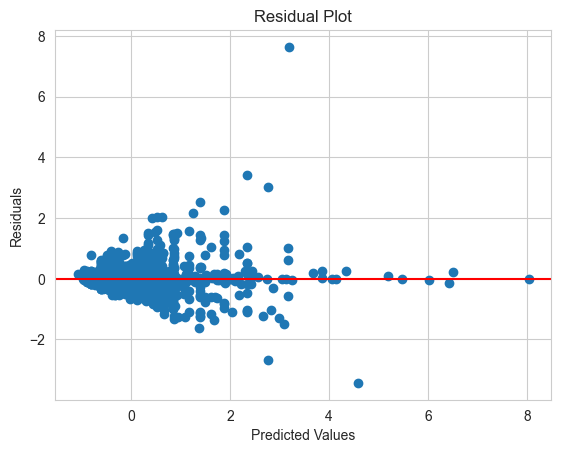

In [36]:
poly_plot_predicted_v_actual(y_train, y_pred_poly)
plot_residuals(y_train, y_pred_poly)

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_poly=cross_val_score(lr_2, X_poly, y_train, cv=10)
avg_cross_val_poly = cross_val_poly.mean()
avg_cross_val_poly

-3.2884986985984557e+19

In [38]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

In [40]:
# compare train and test MSE for polynomials of degrees 1-7
for i in range(7):
  pr = PolynomialFeatures(degree = i+1)
  X_poly = pr.fit_transform(X_train)
  lr_2 = LinearRegression()
  lr_2.fit(X_poly, y_train)
  #Predict results
  y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
  y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))
  
  poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
  print(("Polynomial Train MSE" + " at degree " + str(i+1) + "\t"), str(poly_train_MSE))
  poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
  print(("Polynomial Test MSE" + " at degree " + str(i+1) + "\t"), str(poly_test_MSE))


Polynomial Train MSE at degree 1	 0.450182020228847
Polynomial Test MSE at degree 1	 0.3296427853141805
Polynomial Train MSE at degree 2	 0.29615154181296816
Polynomial Test MSE at degree 2	 3.0018183893724294e+17
Polynomial Train MSE at degree 3	 0.24379523020989013
Polynomial Test MSE at degree 3	 1.2032414733964897e+24
Polynomial Train MSE at degree 4	 0.2189617259746591
Polynomial Test MSE at degree 4	 6.016017195337019e+22
Polynomial Train MSE at degree 5	 0.187674326396502
Polynomial Test MSE at degree 5	 6.610612852936087e+23
Polynomial Train MSE at degree 6	 0.15976169705909155
Polynomial Test MSE at degree 6	 529839905575.09717
Polynomial Train MSE at degree 7	 0.12436014700852904
Polynomial Test MSE at degree 7	 4435916155330.5205


In [79]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [80]:
from numpy.random import rand, randn
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y
def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

### Decision Tree Regression

In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree

In [82]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=12)
cross_val_scores = cross_val_score(regressor, X_train, y_train, cv=10)
average_score = cross_val_scores.mean()
print(f"Average Cross Validation Score for 10 folds: {average_score:.4f}")

regressor.fit(X_train, y_train)
test_score = regressor.score(X_test, y_test)
train_score = regressor.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score:.4f}")
print(f"Accuracy on Test Set: {test_score:.4f}")


Average Cross Validation Score for 10 folds: 0.4787
Accuracy on Train Set: 0.8883
Accuracy on Test Set: 0.3971


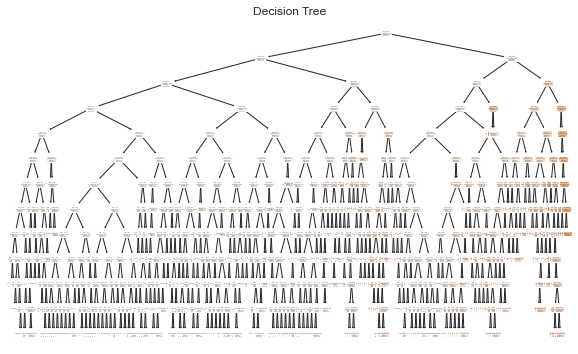

In [83]:
regressor.fit(X_train,y_train)
plt.figure(figsize=(10, 6))
plot_tree(regressor, filled=True)
plt.title("Decision Tree")
plt.show()

In [84]:
# Score based on squared error
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
tree_train_MSE = mean_squared_error(y_train, y_pred_train)
tree_test_MSE = mean_squared_error(y_test, y_pred_test)
print("MSE on training set:", tree_train_MSE)
print("MSE on test set:", tree_test_MSE)

MSE on training set: 0.11442233758134285
MSE on test set: 0.5439877705560399


We can see that both the accuracy and the test set are high, so we can utilize ensemble methods to try and reduce the bias. We will use Decision Tree Boosting technique

In [85]:
from sklearn.ensemble import GradientBoostingRegressor # uses squared loss, default learning rate 0.1

In [86]:
# First, grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 10]
}

boosted_reg = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(estimator=boosted_reg, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

boosted = grid_search.best_estimator_

best_boosted_reg_test_MSE = mean_squared_error(y_test, boosted.predict(X_test))
print("Test set MSE for best boosted regression model:", best_boosted_reg_test_MSE)


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Test set MSE for best boosted regression model: 0.3170637501783764


In [87]:
# boosted = GradientBoostingRegressor(random_state=0, max_depth=12, n_estimators=10000)
# boosted.fit(X_train, y_train)

cross_val_scores_gb = cross_val_score(boosted, X_train, y_train, cv=10)
average_score_gb = cross_val_scores_gb.mean()
print(f"Average Cross Validation Score for 10 folds in Boosted Model: {average_score_gb:.4f}")

Average Cross Validation Score for 10 folds in Boosted Model: 0.6375


In [88]:
test_score_gb = boosted.score(X_test, y_test)
train_score_gb = boosted.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score_gb:.4f}")
print(f"Accuracy on Test Set: {test_score_gb:.4f}")

Accuracy on Train Set: 0.7940
Accuracy on Test Set: 0.6486


In [89]:
y_pred_train_boosted = boosted.predict(X_train)
y_pred_test_boosted = boosted.predict(X_test)

boosted_train_MSE= mean_squared_error(y_train, y_pred_train)
boosted_test_MSE = mean_squared_error(y_test, y_pred_test)

print("MSE on training set:", boosted_train_MSE)
print("MSE on test set:", boosted_test_MSE)

MSE on training set: 0.11442233758134285
MSE on test set: 0.5439877705560399


In [95]:
mse_lin_test=mean_squared_error(y_test, linear_model.predict(X_test))

### Comparing Results from all 3 models

In [98]:
print("Training set MSE:")
print("Linear Regression:", mse_lin)
print("Polynomial Regression:", poly_train_MSE)
print("Regular Decision Tree Regressor:", tree_train_MSE)
print("Boosted Regression:", boosted_train_MSE)

print("\nTest set MSE:")
print("Linear Regression:", mse_lin_test)
print("Polynomial Regression:", poly_test_MSE)
print("Regular Decision Tree Regressor:", tree_test_MSE)
print("Boosted Regression:", boosted_test_MSE)

print("\n10-fold cross-validation:")
print("Linear Regression:", cross_val_results_lin.mean())
print("Polynomial Regression:", avg_cross_val_poly)
print("Regular Decision Tree Regressor:", average_score)
print("Boosted Regression:", average_score_gb)
print("\n")


best_model_train = min(mse_lin, poly_train_MSE, boosted_train_MSE, boosted_train_MSE)
best_model_test = min(mse_lin_test, poly_test_MSE,tree_test_MSE, boosted_test_MSE)

if best_model_train == mse_lin:
    print("\nThe best model for training set is Linear Regression.")
elif best_model_train == poly_train_MSE:
    print("\nThe best model for training set is Polynomial Regression.")
elif best_model_train==boosted_train_MSE:
    print("The best model for train set is Regular Decision Tree Regressor.")
else:
    print("\nThe best model for training set is Boosted Regression.")

if best_model_test == mse_lin_test:
    print("The best model for test set is Linear Regression.")
elif best_model_test == poly_test_MSE:
    print("The best model for test set is Polynomial Regression.")
elif best_model_test==boosted_test_MSE:
    print("The best model for test set is Regular Decision Tree Regressor.")
else:
    print("The best model for test set is Boosted Regression.")


Training set MSE:
Linear Regression: 0.3749666077899912
Polynomial Regression: 0.1243601470092938
Regular Decision Tree Regressor: 0.11442233758134285
Boosted Regression: 0.11442233758134285

Test set MSE:
Linear Regression: 0.3296427853141808
Polynomial Regression: 4435606506416.757
Regular Decision Tree Regressor: 0.5439877705560399
Boosted Regression: 0.5439877705560399

10-fold cross-validation:
Linear Regression: 0.5605922054086668
Polynomial Regression: -2.559436031469238e+20
Regular Decision Tree Regressor: 0.4786684675300868
Boosted Regression: 0.6375358361214667


The best model for train set is Regular Decision Tree Regressor.
The best model for test set is Linear Regression.


### Understand Feature Importance

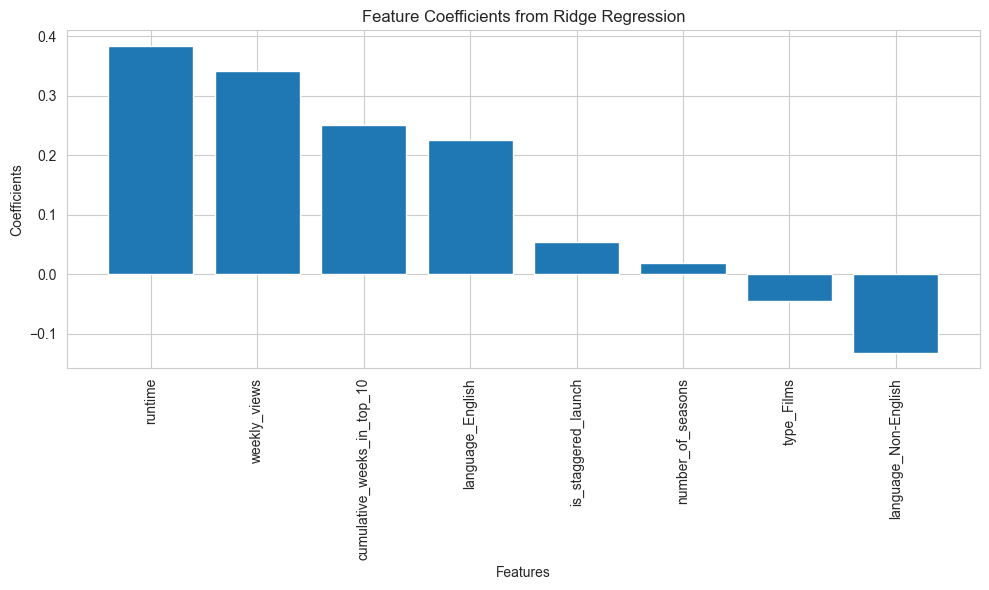

In [61]:
feature_names=['weekly_views','cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons', 'is_staggered_launch', 
'language_English', 'language_Non-English', 'type_Films', 'type_TV', 'available_globally_No', 'available_globally_Yes']
feature_coef = model.coef_

sorted_indices = np.argsort(feature_coef)[::-1]
sorted_feature_importances = feature_coef[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coef)), sorted_feature_importances, align='center')
plt.xticks(range(len(feature_coef)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients from Ridge Regression')
plt.tight_layout()
plt.show()


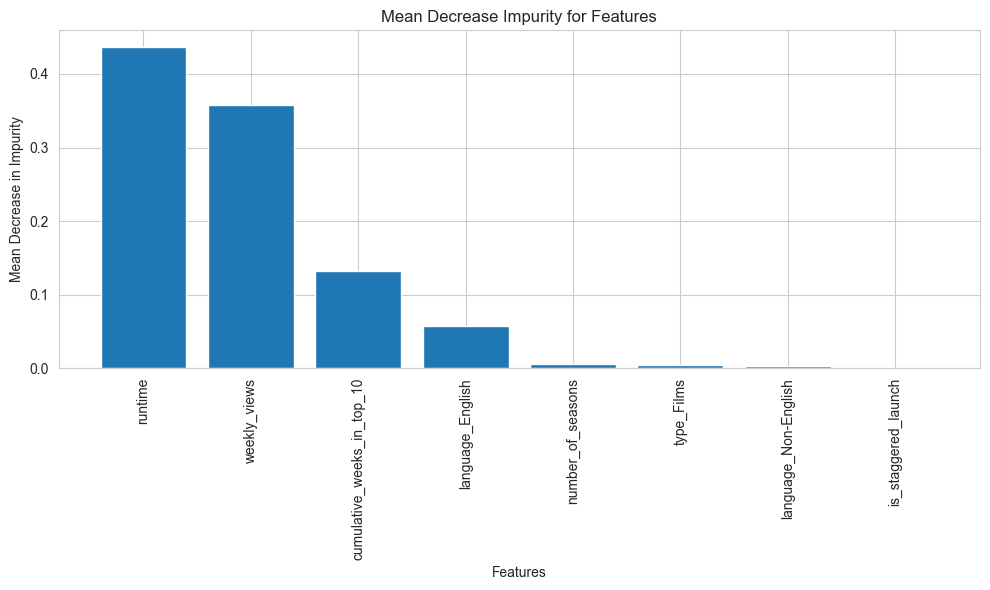

In [62]:
feature_names=['weekly_views','cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons', 'is_staggered_launch', 
'language_English', 'language_Non-English', 'type_Films', 'type_TV', 'available_globally_No', 'available_globally_Yes']
feature_importances = boosted.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(feature_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.title('Mean Decrease Impurity for Features')
plt.tight_layout()
plt.show()